In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import itertools
import random
# Configurations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available():
#     print("CUDA is available. GPU(s) detected:")
#     for i in range(torch.cuda.device_count()):
#         print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
# else:
#     print("CUDA is not available. No GPU detected.")

In [3]:
import os
import shutil
from PIL import Image

# Define paths
input_dir = '/kaggle/input/utkface-new/UTKFace'  # Replace with the path to your UTKFace dataset
young_dir = '/kaggle/working/Input/young'  # Replace with the path where you want to save the young images
old_dir = '/kaggle/working/Input/old'  # Replace with the path where you want to save the old images

# Create directories if they don't exist
os.makedirs(young_dir, exist_ok=True)
os.makedirs(old_dir, exist_ok=True)

# Age brackets
young_min_age, young_max_age = 18, 30
old_min_age, old_max_age = 50, 120

# Function to get age from filename
def get_age_from_filename(filename):
    return int(filename.split('_')[0])

# Process images
for filename in os.listdir(input_dir):
    if filename.endswith('.jpg'):
        age = get_age_from_filename(filename)
        
        if young_min_age <= age <= young_max_age:
            if random.choice([0, 1]):
                shutil.copy(os.path.join(input_dir, filename), os.path.join(young_dir, filename))
        elif old_min_age <= age <= old_max_age:
            if random.choice([0, 1]):
                shutil.copy(os.path.join(input_dir, filename), os.path.join(old_dir, filename))

print("Images have been successfully divided and saved.")


Images have been successfully divided and saved.


In [4]:
len(os.listdir(old_dir)),len(os.listdir(young_dir))

(2515, 4198)

In [5]:
import os
from PIL import Image
from torchvision import transforms,datasets
from torch.utils.data import Dataset, DataLoader

class CustomImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = 0 if 'young' in self.root_dir else 1  # Assign labels based on directory name
        
        return image, label
    

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

young_dataset = CustomImageFolderDataset('/kaggle/working/Input/young', transform=transform)
old_dataset = CustomImageFolderDataset('/kaggle/working/Input/old', transform=transform)

# young_dataset = datasets.ImageFolder('Input/young', transform=transform)
# old_dataset = datasets.ImageFolder('Input/old', transform=transform)

# Combine datasets into a single dataset (optional)
# combined_dataset = torch.utils.data.ConcatDataset([young_dataset, old_dataset])

# Create DataLoaders
batch_size = 6 # Adjust batch size as needed
young_loader = DataLoader(young_dataset, batch_size=batch_size, shuffle=True)
old_loader = DataLoader(old_dataset, batch_size=batch_size, shuffle=True)
# combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

# Example usage of the loaders
for inputs, labels in young_loader:
    # Process inputs and labels as needed
    print(f"Young batch shape: {inputs.shape}, Labels: {labels}")
    break

for inputs, labels in old_loader:
    # Process inputs and labels as needed
    print(f"Old batch shape: {inputs.shape}, Labels: {labels}")
    break

# for inputs, labels in combined_loader:
#     # Process inputs and labels as needed
#     print(f"Combined batch shape: {inputs.shape}, Labels: {labels}")
#     break

# dataset = UTKFaceDataset(root_dir="Input", transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


Young batch shape: torch.Size([6, 3, 128, 128]), Labels: tensor([0, 0, 0, 0, 0, 0])
Old batch shape: torch.Size([6, 3, 128, 128]), Labels: tensor([1, 1, 1, 1, 1, 1])


In [6]:
# Weight initialization
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
        


In [12]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Squeeze: output size (N, channel, 1, 1)
            nn.Conv2d(channel, channel // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1),
            nn.Sigmoid()  # Excitation: channel weights between 0 and 1
        )
    
    def forward(self, x):
        weights = self.fc(x)
        return x * weights  # channel-wise multiplication

class ResnetBlock(nn.Module):
    def __init__(self, dim, reduction=16):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)
        self.se = SEBlock(dim, reduction)
    
    def build_conv_block(self, dim):
        conv_block = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0),
            nn.InstanceNorm2d(dim)
        ]
        return nn.Sequential(*conv_block)
    
    def forward(self, x):
        out = self.conv_block(x)
        out = self.se(out)  # apply squeeze-and-excitation
        return x + out


In [13]:

class GeneratorResNet(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(GeneratorResNet, self).__init__()

        # Initial convolution block
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, 64, 7),
                 nn.InstanceNorm2d(64),
                 nn.ReLU(inplace=True)]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResnetBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, output_nc, 7),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [14]:

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        model = [nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                 nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(64, 128, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(128),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(128, 256, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(256),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(256, 512, 4, stride=1, padding=1),
                  nn.InstanceNorm2d(512),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(512, 1, 4, stride=1, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [15]:

# Initialize models
input_nc = 3
output_nc = 3
netG_A2B = GeneratorResNet(input_nc, output_nc).to(device)
netG_B2A = GeneratorResNet(input_nc, output_nc).to(device)
netD_A = Discriminator(input_nc).to(device)
netD_B = Discriminator(input_nc).to(device)

# Initialize weights
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Losses
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(netD_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(netD_B.parameters(), lr=0.0002, betas=(0.5, 0.999))
print(device)

cuda


In [16]:
import numpy as np
# Adversarial ground truths
def get_adversarial_targets(batch_size, device):
    return Variable(torch.Tensor(np.ones((batch_size, 1, 1, 1))).to(device)), Variable(torch.Tensor(np.zeros((batch_size, 1, 1, 1))).to(device))

In [1]:
num_epochs = 300
# Training Loop
for epoch in range(num_epochs):
    if (epoch%2):
        torch.save(netG_A2B.state_dict(), '/kaggle/working/netG_A2B.pth')
        torch.save(netG_B2A.state_dict(), '/kaggle/working/netG_B2A.pth')
        torch.save(netD_A.state_dict(), '/kaggle/working/netD_A.pth')
        torch.save(netD_B.state_dict(), '/kaggle/working/netD_B.pth')
    for i, (young_img, old_img) in enumerate(zip(young_loader, old_loader)):
        # Set model input
        real_A = Variable(young_img[0].to(device))
        real_B = Variable(old_img[0].to(device))
        # real_A = Variable(batch[0][batch[1]==0].to(device))
        # real_B = Variable(batch[0][batch[1]==1].to(device))

        # Adversarial ground truths
        # valid = Variable(torch.Tensor(np.ones((real_A.size(0), *D_A.output_shape[1:]))).to(device), requires_grad=False)
        # fake = Variable(torch.Tensor(np.zeros((real_A.size(0), *D_A.output_shape[1:]))).to(device), requires_grad=False)
        valid_A, invalid_A = get_adversarial_targets(real_A.size(0), device)
        valid_B, invalid_B = get_adversarial_targets(real_B.size(0), device)
        # ------------------
        #  Train Generators
        # ------------------
        # fake_A = fake_A.expand(-1, 3, -1, -1)
        # print(invalid_A.shape)
        # print(valid_A.shape)
        # print(netD_A(fake_A.detach()).shape)
        optimizer_G.zero_grad()

        # Identity loss
        loss_id_A = criterion_identity(netG_B2A(real_A), real_A)
        loss_id_B = criterion_identity(netG_A2B(real_B), real_B)

        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss
        fake_B = netG_A2B(real_A)
        loss_GAN_A2B = criterion_GAN(netD_B(fake_B), valid_B)
        fake_A = netG_B2A(real_B)
        loss_GAN_B2A = criterion_GAN(netD_A(fake_A), valid_A)

        loss_GAN = (loss_GAN_A2B + loss_GAN_B2A) / 2

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_A = criterion_cycle(recovered_A, real_A)
        recovered_B = netG_A2B(fake_A)
        loss_cycle_B = criterion_cycle(recovered_B, real_B)

        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss
        loss_G = loss_GAN + 10.0 * loss_cycle + 5.0 * loss_identity

        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator A
        # -----------------------

        optimizer_D_A.zero_grad()

        # Real loss
        loss_real = criterion_GAN(netD_A(real_A), valid_A)
        # Fake loss (on batch of previously generated samples)
        loss_fake = criterion_GAN(netD_A(fake_A.detach()), invalid_A)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()

        # -----------------------
        #  Train Discriminator B
        # -----------------------

        optimizer_D_B.zero_grad()

        # Real loss
        loss_real = criterion_GAN(netD_B(real_B), valid_B)
        # Fake loss (on batch of previously generated samples)
        loss_fake = criterion_GAN(netD_B(fake_B.detach()), invalid_B)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

        # --------------
        #  Log Progress
        # --------------
        if(epoch%10== 0 and epoch != 0):
            torch.save(netG_A2B.state_dict(), f'/kaggle/working/netG_A2B_epoch{epoch+140}.pth')
            torch.save(netG_B2A.state_dict(), f'/kaggle/working/netG_B2A_epoch{epoch+140}.pth')
            torch.save(netD_A.state_dict(), f'/kaggle/working/netD_A_epoch{epoch+140}.pth')
            torch.save(netD_B.state_dict(), f'/kaggle/working/netD_B_epoch{epoch+140}.pth')
        if (i%100==0):
            print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i+1}/{len(young_loader)}] "
                  f"[D loss: {loss_D_A.item() + loss_D_B.item()}] "
                  f"[G loss: {loss_G.item()}, adv: {loss_GAN.item()}, cycle: {loss_cycle.item()}, identity: {loss_identity.item()}]")


NameError: name 'young_loader' is not defined

In [42]:
torch.save(netG_A2B.state_dict(), '/kaggle/working/netG_A2B.pth')
torch.save(netG_B2A.state_dict(), '/kaggle/working/netG_B2A.pth')
torch.save(netD_A.state_dict(), '/kaggle/working/netD_A.pth')
torch.save(netD_B.state_dict(), '/kaggle/working/netD_B.pth')

In [32]:
# import torch

# # Assuming netG_A2B, netG_B2A, netD_A, netD_B are initialized models

# # Load weights for netG_A2B
# netG_A2B.load_state_dict(torch.load('/kaggle/input/weights-256/netG_A2B.pth'))

# # Load weights for netG_B2A
# netG_B2A.load_state_dict(torch.load('/kaggle/input/weights-256/netG_B2A.pth'))

# # Load weights for netD_A
# netD_A.load_state_dict(torch.load('/kaggle/input/weights-256/netG_B2A.pth'))

# # Load weights for netD_B
# netD_B.load_state_dict(torch.load('/kaggle/input/weights-256/netD_B.pth'))


In [43]:
from PIL import Image



In [44]:
import cv2


In [45]:
import random
# sampled_items = random.sample(images, 16)

# print(sampled_items)

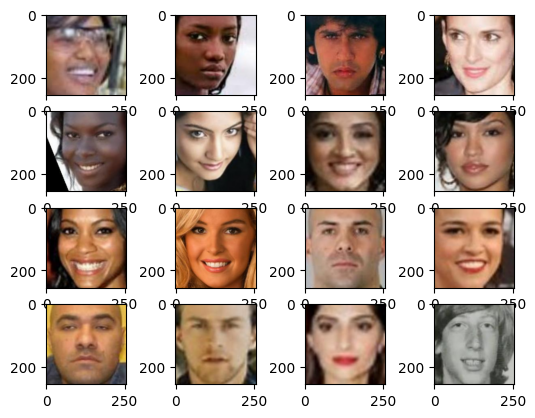

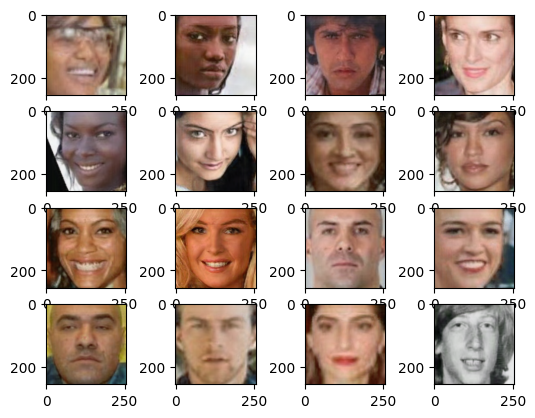

In [118]:
import matplotlib.pyplot as plt
images = os.listdir(young_dir)
sampled_items = random.sample(images, 16)
for x in range(16):
    plt.subplot(4,4,x+1)
    img = cv2.imread(young_dir+'/'+sampled_items[x])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
#     to_tensor = transforms.ToTensor()
#     tensor = to_tensor(img).to(device)
#     old = netG_A2B(tensor)
    plt.imshow(img)
plt.show()
for x in range(16):
    plt.subplot(4,4,x+1)
    img = cv2.imread(young_dir+'/'+sampled_items[x])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    to_tensor = transforms.ToTensor()
    tensor = to_tensor(img).to(device)
    old = netG_A2B(tensor)
    plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
plt.show()

In [47]:
import matplotlib.pyplot as plt

In [48]:
old.shape

torch.Size([3, 256, 256])

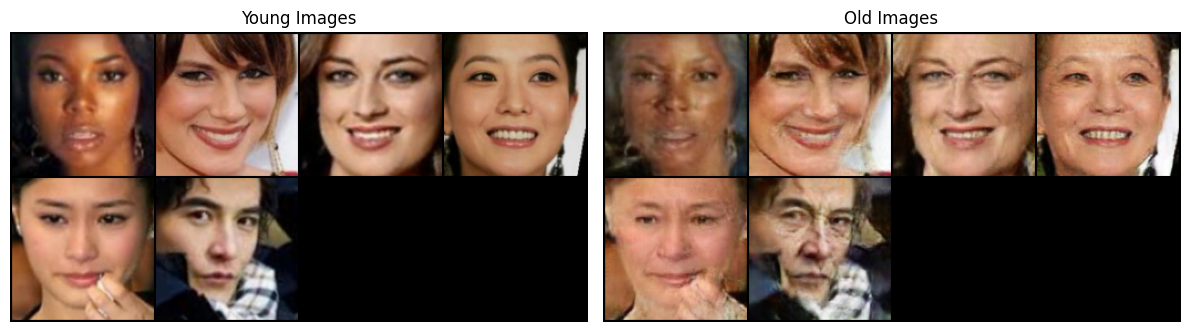

In [49]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
#     plt.show()

# Assuming input_images and output_images are torch tensors
# Convert tensors to grid images
for images, labels in young_loader:
    input_grid = torchvision.utils.make_grid(images, nrow=4, padding=2, normalize=True)
    output_images = netG_A2B(images.to(device))  # Assuming netG_A2B is your generator model
    output_grid = torchvision.utils.make_grid(output_images.cpu(), nrow=4, padding=2, normalize=True)

    # Display input and output images side by side
    plt.figure(figsize=(12, 6))

    # Display input images
    plt.subplot(1, 2, 1)
    imshow(input_grid)
    plt.title('Young Images')

    # Display output images
    plt.subplot(1, 2, 2)
    imshow(output_grid)
    plt.title('Old Images')

    plt.tight_layout()
    plt.show()
    break

In [50]:
images

tensor([[[[-0.8039, -0.8275, -0.8667,  ..., -0.5059, -0.5529, -0.6078],
          [-0.8118, -0.8353, -0.8667,  ..., -0.5529, -0.5765, -0.6078],
          [-0.8196, -0.8431, -0.8745,  ..., -0.6000, -0.5922, -0.5922],
          ...,
          [-0.9373, -0.9373, -0.9373,  ..., -0.8902, -0.9059, -0.9216],
          [-0.9451, -0.9451, -0.9451,  ..., -0.9059, -0.9216, -0.9373],
          [-0.9529, -0.9529, -0.9529,  ..., -0.9216, -0.9294, -0.9373]],

         [[-0.7647, -0.7882, -0.8196,  ..., -0.5765, -0.6235, -0.6784],
          [-0.7725, -0.7961, -0.8196,  ..., -0.6235, -0.6471, -0.6784],
          [-0.7804, -0.8039, -0.8275,  ..., -0.6627, -0.6549, -0.6549],
          ...,
          [-0.9373, -0.9373, -0.9373,  ..., -0.9137, -0.9294, -0.9451],
          [-0.9451, -0.9451, -0.9451,  ..., -0.9294, -0.9451, -0.9608],
          [-0.9529, -0.9529, -0.9529,  ..., -0.9451, -0.9529, -0.9608]],

         [[-0.7412, -0.7647, -0.7961,  ..., -0.5529, -0.6000, -0.6549],
          [-0.7490, -0.7725, -

In [51]:
!ls

Input		     netD_B_epoch120.pth    netG_A2B_epoch50.pth
netD_A.pth	     netD_B_epoch130.pth    netG_A2B_epoch60.pth
netD_A_epoch10.pth   netD_B_epoch20.pth     netG_A2B_epoch70.pth
netD_A_epoch100.pth  netD_B_epoch30.pth     netG_A2B_epoch80.pth
netD_A_epoch110.pth  netD_B_epoch40.pth     netG_A2B_epoch90.pth
netD_A_epoch120.pth  netD_B_epoch50.pth     netG_B2A.pth
netD_A_epoch130.pth  netD_B_epoch60.pth     netG_B2A_epoch10.pth
netD_A_epoch20.pth   netD_B_epoch70.pth     netG_B2A_epoch100.pth
netD_A_epoch30.pth   netD_B_epoch80.pth     netG_B2A_epoch110.pth
netD_A_epoch40.pth   netD_B_epoch90.pth     netG_B2A_epoch120.pth
netD_A_epoch50.pth   netG_A2B.pth	    netG_B2A_epoch130.pth
netD_A_epoch60.pth   netG_A2B_epoch10.pth   netG_B2A_epoch20.pth
netD_A_epoch70.pth   netG_A2B_epoch100.pth  netG_B2A_epoch30.pth
netD_A_epoch80.pth   netG_A2B_epoch110.pth  netG_B2A_epoch40.pth
netD_A_epoch90.pth   netG_A2B_epoch120.pth  netG_B2A_epoch50.pth
netD_B.pth	     netG_A2B_epoch130.pth  netG_B2A_e

In [52]:
!mkdir To_export

In [53]:
!ls

Input		     netD_B_epoch120.pth    netG_A2B_epoch60.pth
To_export	     netD_B_epoch130.pth    netG_A2B_epoch70.pth
netD_A.pth	     netD_B_epoch20.pth     netG_A2B_epoch80.pth
netD_A_epoch10.pth   netD_B_epoch30.pth     netG_A2B_epoch90.pth
netD_A_epoch100.pth  netD_B_epoch40.pth     netG_B2A.pth
netD_A_epoch110.pth  netD_B_epoch50.pth     netG_B2A_epoch10.pth
netD_A_epoch120.pth  netD_B_epoch60.pth     netG_B2A_epoch100.pth
netD_A_epoch130.pth  netD_B_epoch70.pth     netG_B2A_epoch110.pth
netD_A_epoch20.pth   netD_B_epoch80.pth     netG_B2A_epoch120.pth
netD_A_epoch30.pth   netD_B_epoch90.pth     netG_B2A_epoch130.pth
netD_A_epoch40.pth   netG_A2B.pth	    netG_B2A_epoch20.pth
netD_A_epoch50.pth   netG_A2B_epoch10.pth   netG_B2A_epoch30.pth
netD_A_epoch60.pth   netG_A2B_epoch100.pth  netG_B2A_epoch40.pth
netD_A_epoch70.pth   netG_A2B_epoch110.pth  netG_B2A_epoch50.pth
netD_A_epoch80.pth   netG_A2B_epoch120.pth  netG_B2A_epoch60.pth
netD_A_epoch90.pth   netG_A2B_epoch130.pth  netG_B2A_ep

In [54]:
cp *.pth ./To_export

In [56]:
!tar --create . -f weights.tar

tar: ./weights.tar: file is the archive; not dumped


In [57]:
!ls

Input		     netD_B_epoch120.pth    netG_A2B_epoch60.pth
To_export	     netD_B_epoch130.pth    netG_A2B_epoch70.pth
netD_A.pth	     netD_B_epoch20.pth     netG_A2B_epoch80.pth
netD_A_epoch10.pth   netD_B_epoch30.pth     netG_A2B_epoch90.pth
netD_A_epoch100.pth  netD_B_epoch40.pth     netG_B2A.pth
netD_A_epoch110.pth  netD_B_epoch50.pth     netG_B2A_epoch10.pth
netD_A_epoch120.pth  netD_B_epoch60.pth     netG_B2A_epoch100.pth
netD_A_epoch130.pth  netD_B_epoch70.pth     netG_B2A_epoch110.pth
netD_A_epoch20.pth   netD_B_epoch80.pth     netG_B2A_epoch120.pth
netD_A_epoch30.pth   netD_B_epoch90.pth     netG_B2A_epoch130.pth
netD_A_epoch40.pth   netG_A2B.pth	    netG_B2A_epoch20.pth
netD_A_epoch50.pth   netG_A2B_epoch10.pth   netG_B2A_epoch30.pth
netD_A_epoch60.pth   netG_A2B_epoch100.pth  netG_B2A_epoch40.pth
netD_A_epoch70.pth   netG_A2B_epoch110.pth  netG_B2A_epoch50.pth
netD_A_epoch80.pth   netG_A2B_epoch120.pth  netG_B2A_epoch60.pth
netD_A_epoch90.pth   netG_A2B_epoch130.pth  netG_B2A_ep

In [58]:
!ls -la

total 4707568
drwxr-xr-x 5 root root       4096 Apr 17 05:02 .
drwxr-xr-x 5 root root       4096 Apr 16 19:47 ..
drwxr-xr-x 2 root root       4096 Apr 16 19:47 .virtual_documents
drwxr-xr-x 4 root root       4096 Apr 16 19:48 Input
drwxr-xr-x 2 root root       4096 Apr 17 05:00 To_export
-rw-r--r-- 1 root root   11062378 Apr 17 04:58 netD_A.pth
-rw-r--r-- 1 root root   11063130 Apr 16 21:47 netD_A_epoch10.pth
-rw-r--r-- 1 root root   11063144 Apr 17 03:08 netD_A_epoch100.pth
-rw-r--r-- 1 root root   11063144 Apr 17 03:43 netD_A_epoch110.pth
-rw-r--r-- 1 root root   11063144 Apr 17 04:19 netD_A_epoch120.pth
-rw-r--r-- 1 root root   11063144 Apr 17 04:54 netD_A_epoch130.pth
-rw-r--r-- 1 root root   11063130 Apr 16 22:23 netD_A_epoch20.pth
-rw-r--r-- 1 root root   11063130 Apr 16 22:58 netD_A_epoch30.pth
-rw-r--r-- 1 root root   11063130 Apr 16 23:34 netD_A_epoch40.pth
-rw-r--r-- 1 root root   11063130 Apr 17 00:09 netD_A_epoch50.pth
-rw-r--r-- 1 root root   11063130 Apr 17 00:45 netD_A_e

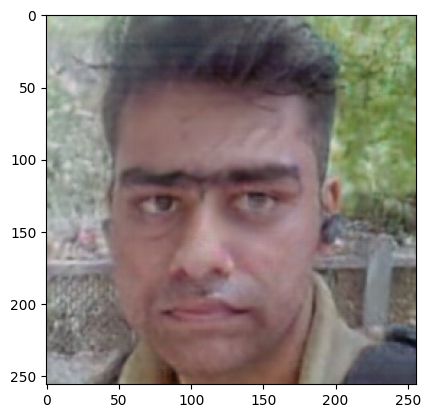

In [69]:

img = cv2.imread("/kaggle/input/images/WhatsApp Image 2024-06-28 at 10.46.12.jpeg")[200:800,600:1200]
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256,256))
to_tensor = transforms.ToTensor()
tensor = to_tensor(img).to(device)
old = netG_A2B(tensor)
# plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
plt.show()

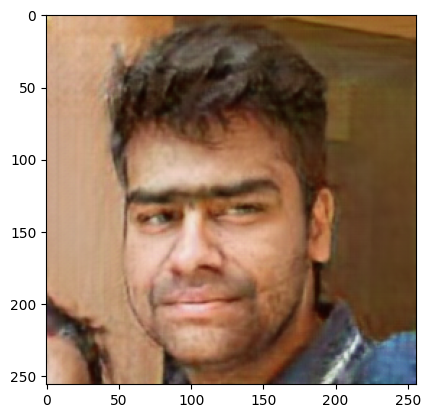

In [70]:

img = cv2.imread("/kaggle/input/test-image-2/Screenshot from 2024-06-28 11-10-38.png")
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256,256))
to_tensor = transforms.ToTensor()
tensor = to_tensor(img).to(device)
old = netG_A2B(tensor)
# plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
plt.show()

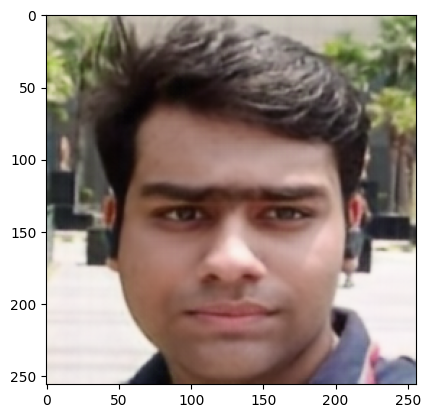

In [76]:

img = cv2.imread("/kaggle/input/images/WhatsApp Image 2024-06-28 at 10.45.27.jpeg")[280:820,620:1100]
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256,256))
to_tensor = transforms.ToTensor()
tensor = to_tensor(img).to(device)
old = netG_B2A(tensor)
plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
# plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
plt.show()

In [78]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.1 MB/s eta 0:00:00a 0:00:01
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114248 sha256=bf9640232036e18c35c6b14999e70630b3f9a2093968b031f08bf053afccf001
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

1404 386 64 64
677 435 370 370
1264 478 58 58
1486 465 107 107
209 685 77 77
196 954 94 94


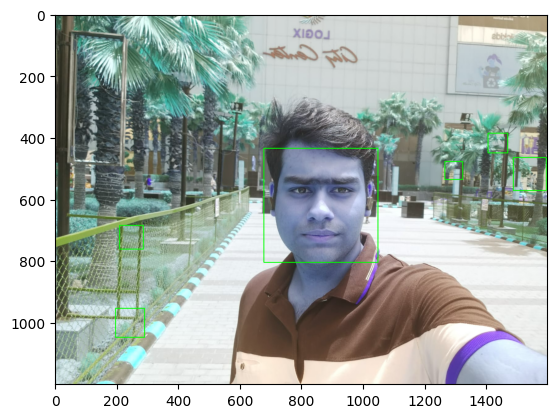

In [85]:
import cv2

# Load the pre-trained face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


# Read image from file
img = cv2.imread('/kaggle/input/images/WhatsApp Image 2024-06-28 at 10.45.27.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.1, 5)
for (x, y, w, h) in faces:
    print(x,y,w,h)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # img = img[x:x+w,y:y+h]
plt.imshow(img)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.resize(img, (256,256))
    # to_tensor = transforms.ToTensor()
    # tensor = to_tensor(img).to(device)
    # old = netG_B2A(tensor)
    # plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
    # # plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
plt.show()


[713, 406, 294, 405]


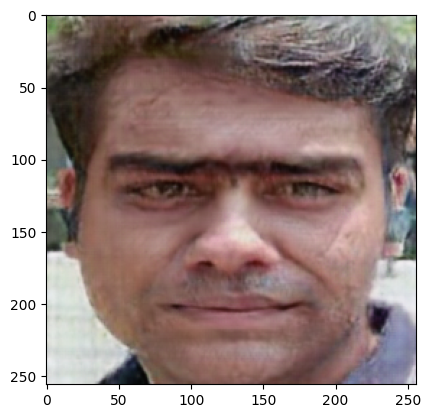

In [105]:
from deepface import DeepFace
import cv2

# Load image
img_path = '/kaggle/input/images/WhatsApp Image 2024-06-28 at 10.45.27.jpeg'
img = cv2.imread('/kaggle/input/images/WhatsApp Image 2024-06-28 at 10.45.27.jpeg')

# Analyze using RetinaFace to get face region
# RetinaFace returns more accurate bounding boxes
detections = DeepFace.extract_faces(img_path=img_path, detector_backend='retinaface', enforce_detection=False)

# Draw bounding boxes
for face in detections:
    x, y, w, h = list(face['facial_area'].values())[:4]
    print(list(face['facial_area'].values())[:4])
    img = img[ y-50:y + h,x-30:x + w+30] 

# plt.imshow(img)
img = cv2.resize(img, (256,256))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
to_tensor = transforms.ToTensor()
tensor = to_tensor(img).to(device)
old = netG_A2B(tensor)
plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
# plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
plt.show()

[775, 214, 291, 405]


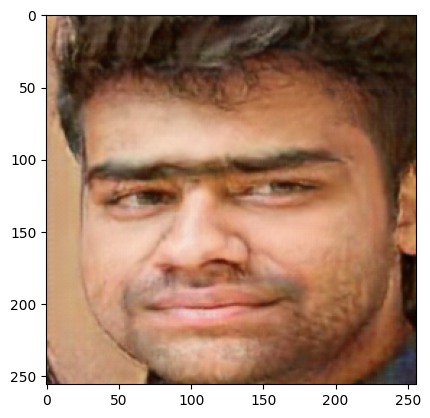

[483, 575, 244, 306]


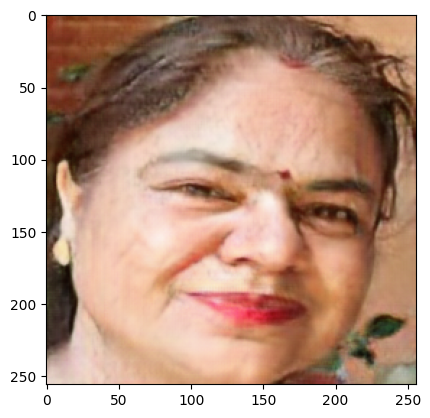

[1398, 364, 53, 63]


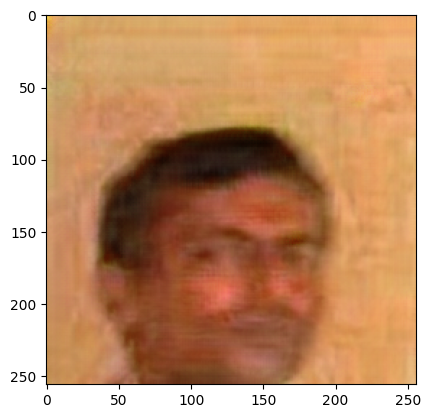

In [109]:
from deepface import DeepFace
import cv2

# Load image
img_path = '/kaggle/input/images/WhatsApp Image 2024-06-28 at 10.45.54.jpeg'
img1 = cv2.imread(img_path)

# Analyze using RetinaFace to get face region
# RetinaFace returns more accurate bounding boxes
detections = DeepFace.extract_faces(img_path=img_path, detector_backend='retinaface', enforce_detection=False)

# Draw bounding boxes
for face in detections:
    x, y, w, h = list(face['facial_area'].values())[:4]
    print(list(face['facial_area'].values())[:4])
    img = img1[ y-50:y + h,x-30:x + w+30] 
    img = cv2.resize(img, (256,256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    to_tensor = transforms.ToTensor()
    tensor = to_tensor(img).to(device)
    old = netG_A2B(tensor)
    plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
    # plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
    plt.show()

[703, 308, 337, 472]


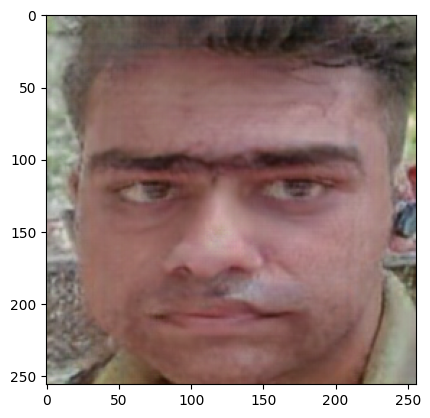

In [110]:
from deepface import DeepFace
import cv2

# Load image
img_path = '/kaggle/input/images/WhatsApp Image 2024-06-28 at 10.46.12.jpeg'
img1 = cv2.imread(img_path)

# Analyze using RetinaFace to get face region
# RetinaFace returns more accurate bounding boxes
detections = DeepFace.extract_faces(img_path=img_path, detector_backend='retinaface', enforce_detection=False)

# Draw bounding boxes
for face in detections:
    x, y, w, h = list(face['facial_area'].values())[:4]
    print(list(face['facial_area'].values())[:4])
    img = img1[ y-50:y + h,x-30:x + w+30] 
    img = cv2.resize(img, (256,256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    to_tensor = transforms.ToTensor()
    tensor = to_tensor(img).to(device)
    old = netG_A2B(tensor)
    plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
    # plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
    plt.show()

[265, 311, 359, 538]


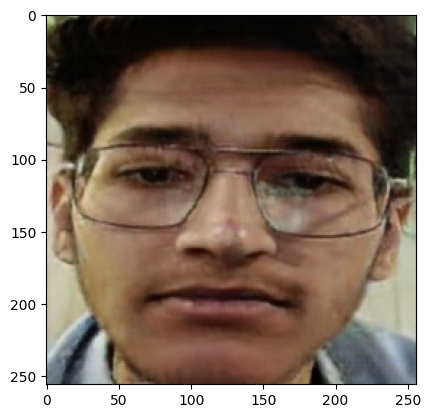

In [117]:
from deepface import DeepFace
import cv2

# Load image
img_path = '/kaggle/input/fariz-img/WhatsApp Image 2025-04-16 at 21.59.20_468cfb91.jpg'
img1 = cv2.imread(img_path)

# Analyze using RetinaFace to get face region
# RetinaFace returns more accurate bounding boxes
detections = DeepFace.extract_faces(img_path=img_path, detector_backend='retinaface', enforce_detection=False)

# Draw bounding boxes
for face in detections:
    x, y, w, h = list(face['facial_area'].values())[:4]
    print(list(face['facial_area'].values())[:4])
    img = img1[ y-50:y + h,x-30:x + w+30] 
    img = cv2.resize(img, (256,256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    to_tensor = transforms.ToTensor()
    tensor = to_tensor(img).to(device)
    old = netG_A2B(tensor)
    plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
    # plt.imshow((old.to('cpu').detach().permute(1, 2, 0).numpy()+1)/2)
    plt.show()